## 1. MLP for classification (**)

Use the heart dataset that you worked with in the lab in Machine learning course and train an MLP on it. Gather your knowledge of MLP from the lecture and from the previous exercise to try and see if you can outperform your previous model. Note that an important part is to perform systematic scientific experimentation. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/cardio_train.csv', sep=';').drop(columns=['id'])
df.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [3]:
df = df.query('140 < height < 230')
df = df.query('40 < weight < 190')
df = df.query('60 < ap_hi < 250')
df = df.query('30 < ap_lo < 140')
df['age'] = (df['age'] / 365.25)
df = df.query('age > 35')
df = pd.get_dummies(columns=['gender'], data=df, drop_first=True, dtype=int, prefix='').rename(columns={'_2': 'male'})

In [4]:
df['BMI'] = df['weight'] / (df['height'] / 100)**2 # Divided på 100 to convert cm to m.
df = df.query('BMI >= 18.5') # Removed underweight patients.

bmi_categories = pd.cut(df['BMI'], [18.5, 24.9, 29.9, 34.9, 40, np.inf], labels=['Normal weight', 'Overweight', 'Obese (class I)', 'Obese (class II)', 'Obese (class III)'])
bmi_categories = pd.get_dummies(bmi_categories, drop_first=False, dtype=int)
df = pd.concat([df, bmi_categories], axis=1)

# The pd.cut() function had trouble taking more than one column as input, which is why it is done in a "clunkier" way.
df['BP Healthy'] = ((df['ap_hi'] < 120) & (df['ap_lo'] < 80)).astype(int)
df['BP Elevated'] = ((df['ap_hi'] >= 120) & (df['ap_hi'] < 130) & (df['ap_lo'] < 80)).astype(int)
df['BP Hypertension (stage 1)'] = (((df['ap_hi'] >= 130) & (df['ap_hi'] < 140)) | ((df['ap_lo'] >= 80) & (df['ap_lo'] < 90))).astype(int)
df['BP Hypertension (stage 2)'] = ((df['ap_hi'] >= 140) | (90 <= df['ap_lo'])).astype(int)
df['BP Hypertensive Crisis'] = ((df['ap_hi'] >= 180) | (120 < df['ap_lo'])).astype(int)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67863 entries, 0 to 69999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        67863 non-null  float64
 1   height                     67863 non-null  int64  
 2   weight                     67863 non-null  float64
 3   ap_hi                      67863 non-null  int64  
 4   ap_lo                      67863 non-null  int64  
 5   cholesterol                67863 non-null  int64  
 6   gluc                       67863 non-null  int64  
 7   smoke                      67863 non-null  int64  
 8   alco                       67863 non-null  int64  
 9   active                     67863 non-null  int64  
 10  cardio                     67863 non-null  int64  
 11  male                       67863 non-null  int64  
 12  BMI                        67863 non-null  float64
 13  Normal weight              67863 non-null  int64  


In [6]:
X, y = df.drop(columns=['cardio', 'BMI', 'ap_hi', 'ap_lo', 'height']), df['cardio']

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.15)

scaled_X_train_val = scaler.fit_transform(X_train_val)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

scaled_X_train = scaler.fit_transform(X_train)

In [8]:
X_train.shape

(54290, 18)

In [9]:
from keras import Sequential, layers

model = Sequential(
    [
        layers.InputLayer(shape=(X_train.shape[1],)),
        layers.Dense(15, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ],
    name='cardio_classifier_model'
)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "cardio_classifier_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 15)             │           285 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301 (1.18 KB)

 Trainable params: 301 (1.18 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from keras.callbacks import EarlyStopping

stopper = EarlyStopping(monitor='val_loss', mode='min', patience=5)

In [11]:
model.fit(scaled_X_train, y_train, epochs=10, callbacks=[stopper])

Epoch 1/10
1697/1697 ━━━━━━━━━━━━━━━━━━━━ 2s 712us/step - accuracy: 0.6966 - loss: 0.5926
Epoch 2/10
 170/1697 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - accuracy: 0.7249 - loss: 0.5645

c:\KODA\ITHS\9_Deep Learning\DeepLearning\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


1697/1697 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step - accuracy: 0.7239 - loss: 0.5627
Epoch 3/10
1697/1697 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - accuracy: 0.7233 - loss: 0.5632
Epoch 4/10
1697/1697 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step - accuracy: 0.7274 - loss: 0.5586
Epoch 5/10
1697/1697 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/step - accuracy: 0.7282 - loss: 0.5587
Epoch 6/10
1697/1697 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.7293 - loss: 0.5576
Epoch 7/10
1697/1697 ━━━━━━━━━━━━━━━━━━━━ 1s 631us/step - accuracy: 0.7257 - loss: 0.5596
Epoch 8/10
1697/1697 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step - accuracy: 0.7320 - loss: 0.5555
Epoch 9/10
1697/1697 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step - accuracy: 0.7296 - loss: 0.5565
Epoch 10/10
1697/1697 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step - accuracy: 0.7298 - loss: 0.5558


<Axes: xlabel='Epochs', ylabel='Loss/Accuracy'>

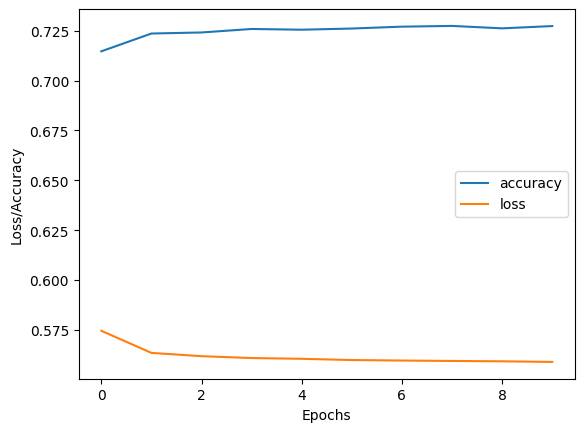

In [12]:
pd.DataFrame(model.history.history).plot(xlabel='Epochs', ylabel='Loss/Accuracy')

In [13]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [14]:
y_pred = model.predict(scaled_X_test)

y_pred = np.round(y_pred)

425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


              precision    recall  f1-score   support

           0       0.71      0.76      0.73      6786
           1       0.74      0.69      0.72      6787

    accuracy                           0.72     13573
   macro avg       0.73      0.72      0.72     13573
weighted avg       0.73      0.72      0.72     13573



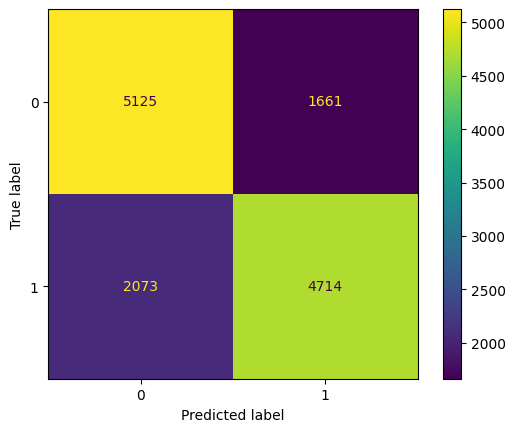

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()